In [20]:
import os
import torch
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys 
sys.path.append('..')
from den import DEN
from dataset import NyuV2
import utils

%matplotlib inline

In [14]:
data_path = '../data/nyu_v2/'
batch_size = 16
depth_size = (25, 32)
seed = 2
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_loader = data.DataLoader(NyuV2(os.path.join(data_path, 'val')),
                              batch_size=batch_size, shuffle=True)

In [28]:
wts_file = '../models/full_resnet/149_resnet_model.pt'
model_file = '../models/den_dbe/008_model.pt'
den = DEN(wts_file)
den.load_state_dict(torch.load(model_file))
den = den.to(device)

In [3]:
params_to_update = []
for name,param in den.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

	 fc.weight
	 fc.bias
	 aux_modules.0.aux.0.weight
	 aux_modules.0.aux.0.bias
	 aux_modules.0.aux.3.weight
	 aux_modules.0.aux.3.bias
	 aux_modules.1.aux.0.weight
	 aux_modules.1.aux.0.bias
	 aux_modules.1.aux.3.weight
	 aux_modules.1.aux.3.bias
	 aux_modules.2.aux.0.weight
	 aux_modules.2.aux.0.bias
	 aux_modules.2.aux.3.weight
	 aux_modules.2.aux.3.bias
	 aux_modules.3.aux.0.weight
	 aux_modules.3.aux.0.bias
	 aux_modules.3.aux.3.weight
	 aux_modules.3.aux.3.bias
	 aux_modules.4.aux.0.weight
	 aux_modules.4.aux.0.bias
	 aux_modules.4.aux.3.weight
	 aux_modules.4.aux.3.bias
	 aux_modules.5.aux.0.weight
	 aux_modules.5.aux.0.bias
	 aux_modules.5.aux.3.weight
	 aux_modules.5.aux.3.bias
	 aux_modules.6.aux.0.weight
	 aux_modules.6.aux.0.bias
	 aux_modules.6.aux.3.weight
	 aux_modules.6.aux.3.bias
	 aux_modules.7.aux.0.weight
	 aux_modules.7.aux.0.bias
	 aux_modules.7.aux.3.weight
	 aux_modules.7.aux.3.bias
	 aux_modules.8.aux.0.weight
	 aux_modules.8.aux.0.bias
	 aux_modules.8.aux.3.weig

In [4]:
img = Tensor(1, 3, 224, 224).normal_()

In [5]:
d_hat = den(img)

In [6]:
d_hat.shape

torch.Size([1, 800])

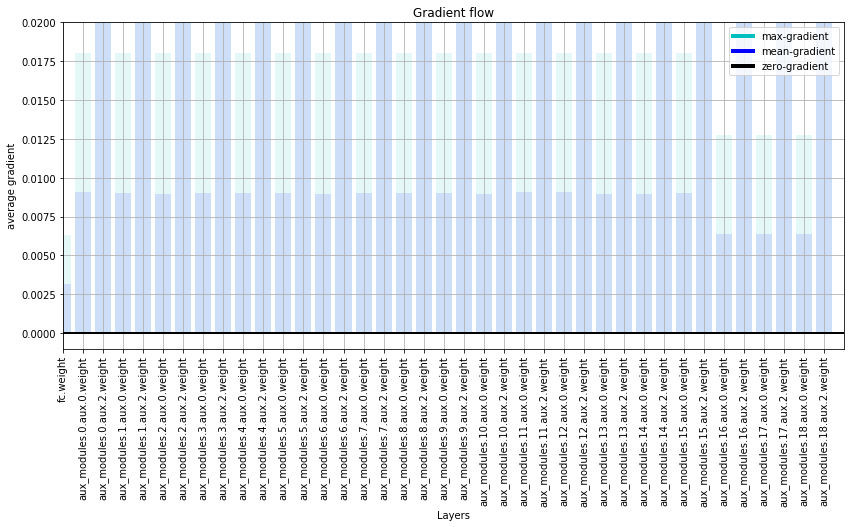

In [28]:
utils.plot_grad_flow(den.named_parameters(), 'd')

In [29]:
def evaluate(model):
    model.eval()
    test_loss = 0
    for batch, (data, labels) in enumerate(test_loader):
        data = data.to(device)
        labels = labels.to(device)
        depth_maps = model(data)
        loss = F.mse_loss(depth_maps, labels, reduction='sum')
        test_loss += loss.item()
    
    return (test_loss / len(test_loader.dataset))**0.5

In [30]:
evaluate(den)

/anaconda/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda/envs/py36/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


2.598748754685427

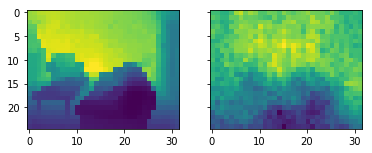

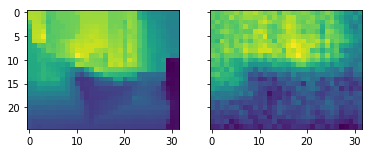

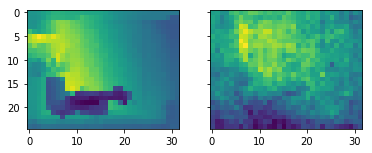

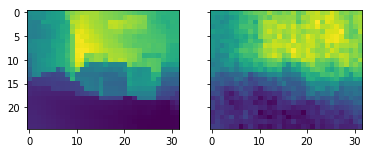

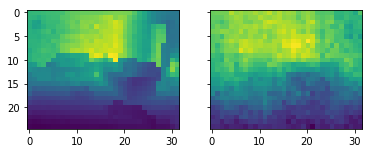

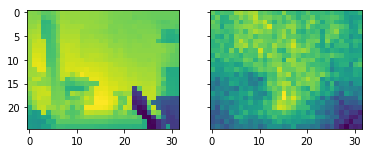

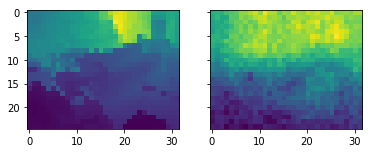

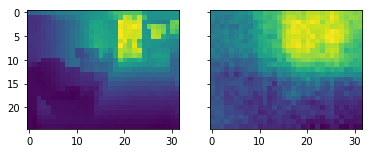

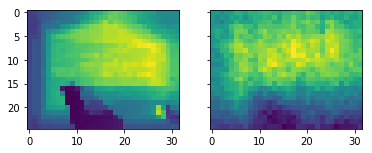

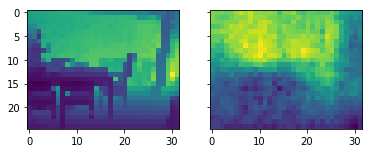

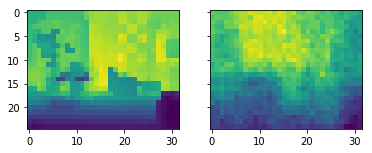

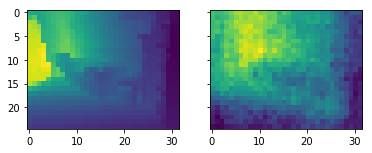

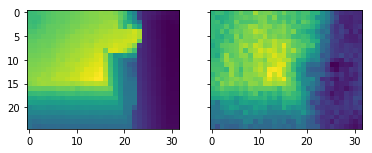

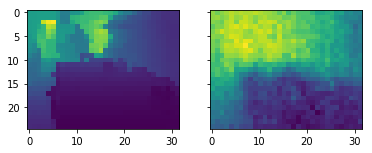

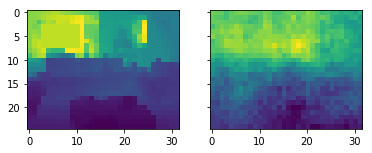

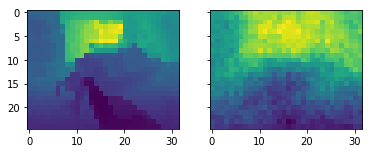

In [33]:
sample = next(iter(test_loader))
d = sample[1]
den.eval()
d_pred = den(sample[0].to(device))

for i in range(batch_size):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(d[i].view(depth_size))
    ax2.imshow(d_pred[i].view(depth_size).cpu().data.numpy())